# Deploy Keras Model to the Cloud
1. Download data
2. Hot Encode Categorical Columns
3. Develop Model (use: ```RMSprop(lr=, rho=, epsilon=, decay=)```)
3. Create Storage Bucket (should already exist)
4. Authenticate on Google Cloud Platform
5. Deploy your model using the ```gcloud``` tool

In [1]:
!wget https://storage.googleapis.com/nicksdemobucket/bank.csv

--2021-06-13 16:38:56--  https://storage.googleapis.com/nicksdemobucket/bank.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80, 2607:f8b0:4023:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [application/octet-stream]
Saving to: ‘bank.csv’

bank.csv            100%[===================>]   4.40M  --.-KB/s    in 0.08s   

2021-06-13 16:38:56 (52.0 MB/s) - ‘bank.csv’ saved [4610348/4610348]



In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('bank.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [3]:
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [4]:
# Get all categorical columns
categorical = df.select_dtypes(include='object').columns
print(categorical)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


In [5]:
# Hot encode all categorical columns
for i in categorical:
        new_cols = pd.get_dummies(df[i], prefix=i)
        df = df.drop(i, axis=1)
        df = df.join(new_cols)

df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [7]:
# Null value
df.isna().any()

age                    False
balance                False
day                    False
duration               False
campaign               False
pdays                  False
previous               False
job_admin.             False
job_blue-collar        False
job_entrepreneur       False
job_housemaid          False
job_management         False
job_retired            False
job_self-employed      False
job_services           False
job_student            False
job_technician         False
job_unemployed         False
job_unknown            False
marital_divorced       False
marital_married        False
marital_single         False
education_primary      False
education_secondary    False
education_tertiary     False
education_unknown      False
default_no             False
default_yes            False
housing_no             False
housing_yes            False
loan_no                False
loan_yes               False
contact_cellular       False
contact_telephone      False
contact_unknow

In [6]:
# TODO - Process Data
# Split data for train & test
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(df, test_size=0.15, random_state=10, shuffle=True)
print(Train.shape)
print(Test.shape)

(38429, 53)
(6782, 53)


In [7]:
# Transform features by scaling each feature to a given range.
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X_Train = min_max_scaler.fit_transform(Train.drop(['y_0','y_1'], axis=1))
y_Train = Train[['y_0','y_1']].values

X_Test = min_max_scaler.fit_transform(Test.drop(['y_0','y_1'], axis=1))
y_Test = Test[['y_0','y_1']].values

In [8]:
print(X_Train.shape)
print(y_Train.shape)
print(X_Test.shape)
print(y_Test.shape)

(38429, 51)
(38429, 2)
(6782, 51)
(6782, 2)


In [9]:
print(X_Train)

[[0.4025974  0.06335456 0.8        ... 0.         0.         1.        ]
 [0.46753247 0.0654468  0.96666667 ... 1.         0.         0.        ]
 [0.2987013  0.07569696 1.         ... 0.         0.         1.        ]
 ...
 [0.16883117 0.07774331 0.03333333 ... 0.         0.         1.        ]
 [0.11688312 0.06594233 0.1        ... 0.         0.         1.        ]
 [0.4025974  0.07752308 0.93333333 ... 0.         0.         1.        ]]


In [10]:
print(y_Train)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [11]:
# TODO - Develop Model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import tensorflow.keras.backend as K

In [12]:
#random.seed(111)
K.clear_session()

# Setup the layers
model = tf.keras.Sequential()
model.add(Dense(input_dim=51, units=16,activation='relu'))   
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))     
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation ='softmax'))                                 

earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

h = model.fit(X_Train, y_Train, batch_size=16, epochs=100, validation_split=0.2, callbacks=[earlyStopping_callback])

Epoch 1/100
1922/1922 [==============================] - 4s 2ms/step - loss: 0.3527 - accuracy: 0.8659 - val_loss: 0.2804 - val_accuracy: 0.8865
Epoch 2/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2601 - accuracy: 0.8978 - val_loss: 0.2529 - val_accuracy: 0.8940
Epoch 3/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2495 - accuracy: 0.8995 - val_loss: 0.2535 - val_accuracy: 0.8933
Epoch 4/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2476 - accuracy: 0.8995 - val_loss: 0.2534 - val_accuracy: 0.8940
Epoch 5/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2421 - accuracy: 0.9018 - val_loss: 0.2437 - val_accuracy: 0.8920
Epoch 6/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2414 - accuracy: 0.8995 - val_loss: 0.2398 - val_accuracy: 0.8959
Epoch 7/100
1922/1922 [==============================] - 3s 2ms/step - loss: 0.2378 - accuracy: 0.9003 - val_loss: 0.2412 - val_ac

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,570
Trainable params: 1,506
Non-trainable params: 64
_________________________________________________________________


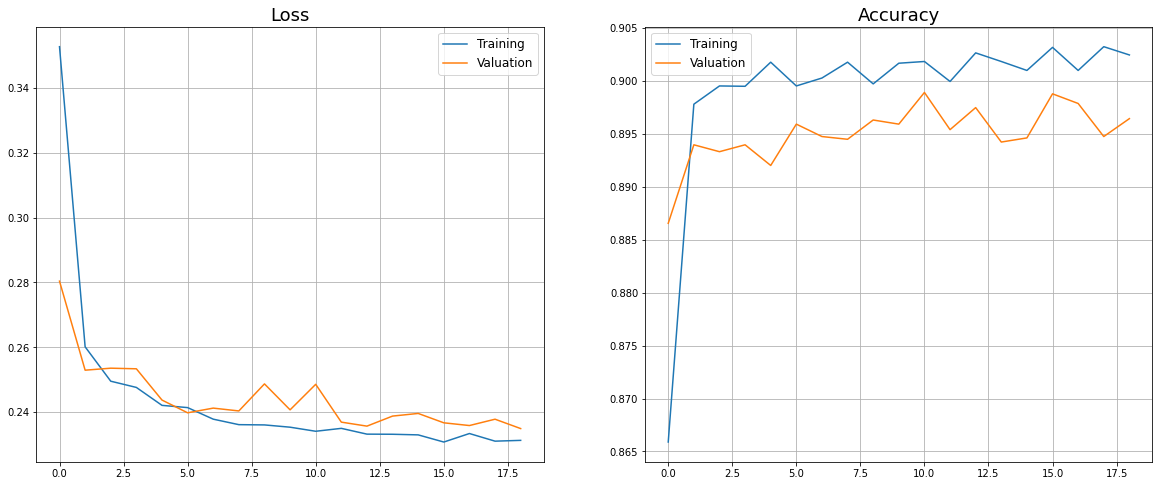

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20,8))

axs[0].plot(h.history['loss'], label='Training')
axs[0].plot(h.history['val_loss'], label='Valuation')
axs[0].set_title('Loss', fontsize=18)
axs[0].grid(True)
axs[0].legend(fontsize=12)

axs[1].plot(h.history['accuracy'], label='Training')
axs[1].plot(h.history['val_accuracy'], label='Valuation')
axs[1].set_title('Accuracy', fontsize=18)
axs[1].grid(True)
axs[1].legend(fontsize=12)

In [15]:
# Evaluate the model on the test data 
print("Evaluate on test data")
results = model.evaluate(X_Test, y_Test, batch_size=64)
print("Test Loss, Test Accuracy:", results)

Evaluate on test data
106/106 [==============================] - 0s 1ms/step - loss: 0.2351 - accuracy: 0.9003
Test Loss, Test Accuracy: [0.23507060110569, 0.9003244042396545]


In [16]:
Y_pred=model.predict(X_Test[:10])
print(Y_pred)

[[0.98732346 0.01267654]
 [0.9970114  0.00298852]
 [0.6369065  0.3630934 ]
 [0.950125   0.04987498]
 [0.99194497 0.008055  ]
 [0.9883532  0.01164686]
 [0.95459247 0.04540759]
 [0.9966575  0.00334245]
 [0.93854916 0.06145079]
 [0.4596276  0.54037243]]


In [17]:
a=X_Test[0]
b=a.reshape(-1,51)
Choose_pred=np.argmax(model.predict(b), axis=-1)

print(Choose_pred[0])

0


In [18]:
# TODO -  Set project name, bucket name, authenticate to GCP

PROJECT_ID = "marie-noel-lepage" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "model_mnl_1" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"}

In [19]:
! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
marie-noel-lepage


In [20]:
# Authenticate
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [21]:
# Job directory
JOB_DIR = 'gs://' + BUCKET_NAME + '/model_mnl_1'
print(JOB_DIR)

gs://model_mnl_1/model_mnl_1


In [22]:
# save model
export_path = tf.keras.models.save_model(model, JOB_DIR + '/keras_export')
print(type(export_path))
print("Model exported to: ", export_path)

INFO:tensorflow:Assets written to: gs://model_mnl_1/model_mnl_1/keras_export/assets
<class 'NoneType'>
Model exported to:  None


In [ ]:
# TODO -  Deploy Model

In [24]:
# Show bucket with save model
a = "model_mnl_1" # Model name  that TensorFlow serving is keep it up and running ~~~

print('Display what is in the bucket :\n')
!gsutil ls -al gs://$a

Display what is in the bucket :

                                 gs://model_mnl_1/model_mnl_1/


In [25]:
# Work towards model version instance
MODEL_NAME = 'model_mnl_1'
MODEL_VERSION = 'v1'

! gcloud ai-platform models create $MODEL_NAME --region $REGION

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/marie-noel-lepage/models/model_mnl_1].


In [26]:
# Get a list of directories in the keras_export parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/
print("! gsutil ls $JOB_DIR/keras_export/ \n")
print(KERAS_EXPORT_DIRS)
print("-------------------------")

! gsutil ls $JOB_DIR/keras_export/ 

['gs://model_mnl_1/model_mnl_1/keras_export/', 'gs://model_mnl_1/model_mnl_1/keras_export/keras_metadata.pb', 'gs://model_mnl_1/model_mnl_1/keras_export/saved_model.pb', 'gs://model_mnl_1/model_mnl_1/keras_export/assets/', 'gs://model_mnl_1/model_mnl_1/keras_export/variables/']
-------------------------


In [27]:
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[0]
print("Saved_model_path \n")
print(SAVED_MODEL_PATH)

Saved_model_path 

gs://model_mnl_1/model_mnl_1/keras_export/


In [28]:
# Create model version based on that SavedModel directory
!gcloud config set ai_platform/region us-central1
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 2.2 \
  --python-version 3.7 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

Updated property [ai_platform/region].
Using endpoint [https://us-central1-ml.googleapis.com/]


In [29]:
# TODO -  Test Model
X_Test[:1]

array([[0.49333333, 0.10738965, 0.63333333, 0.07421716, 0.05555556,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

In [30]:
# Create file with features to send to model
with open('test.json', 'w') as f:
  for item in X_Test[:1]:
    item = list(item)
    f.write("%s\n" % item)
! cat test.json

[0.4933333333333334, 0.1073896507392329, 0.6333333333333333, 0.07421716144774299, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [31]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances test.json

Using endpoint [https://us-central1-ml.googleapis.com/]
[[0.987323463, 0.0126765342]]


In [32]:
#Retrieve Predicted Value from model
shelloutputnew = ! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances test.json

In [33]:
# Predicted y-values
f = shelloutputnew[1]
print('Shelloutputnew (Type) :' + str(type(f)))
print('Output: ' + str(f))
print('\n')

Shelloutputnew (Type) :<class 'str'>
Output: [[0.987323463, 0.0126765342]]




In [34]:
f_new = float(f[2:-20])
print('f_new_converted (Type): ' + str(type(f_new)))

f_new_converted (Type): <class 'float'>


In [35]:
range_1 = f_new - 0
range_2 = 1- f_new

if range_1 > range_2:
  print('y-predicted: 0 (No)')

elif range_1 < range_2:
  print('y-predicted: 1 (Yes)')

else:
  print('y-predicted: Undecided')

y-predicted: 0 (No)
